<a href="https://colab.research.google.com/github/AIREheart/Computational-Neuroscience/blob/main/Tutorials/Multilayer_Perceptron_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-layer perceptron activity

In this activity, you will make a multi-layer perceptron (MLP) model in the PyTorch deep learning package to perform classification of hand-written digits in the classic MNIST dataset.

In [ ]:
import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.nn.functional as F  # Functional module, includes activation functions
import torch.optim as optim  # Optimization module
import torchvision  # Vision / image processing package built on top of torch

from matplotlib import pyplot as plt  # Plotting and visualization
from sklearn.metrics import accuracy_score  # Computing accuracy metric

# 1. Setup the data

In [ ]:
# Common practice to normalize input data to neural networks (0 mean, unit variance)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # All inputs to PyTorch neural networks must be torch.Tensor
    torchvision.transforms.Normalize(mean=0.1307, std=0.3081)  # Subtracts mean and divides by std. Note that the raw data is between [0, 1]
])

# Download the MNIST data and lazily apply the transformation pipeline
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

# Setup data loaders
# Note: Iterating through the dataloader yields batches of (inputs, targets)
# where inputs is a torch.Tensor of shape (B, 1, 28, 28) and targets is a torch.Tensor of shape (B,)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(mnist, torch.arange(5000)),
    batch_size=1000,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(mnist, torch.arange(5000, 10000)),
    batch_size=1000,
    shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 91349290.52it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36563747.00it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30190906.77it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4238159.90it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



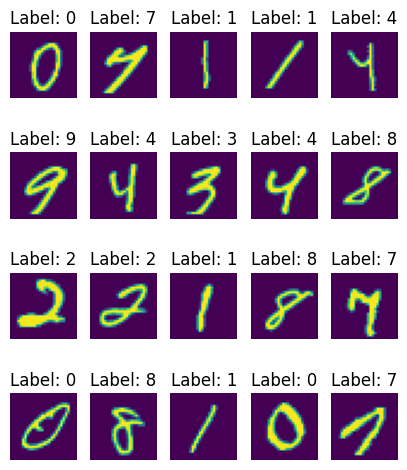

Each image is a torch.Tensor and has shape torch.Size([1, 28, 28]).
The labels are the integers 0 to 9, representing the digits.


In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(5, 6))

plot_images = []
plot_labels = []

for i, ax in enumerate(axs.flatten(), start=1000):
    (image, label) = mnist[i]

    # Save this data for later
    plot_images.append(image)
    plot_labels.append(label)

    # Plot each image
    ax.imshow(image.squeeze(), cmap="viridis")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

plot_images = torch.cat(plot_images)  # Combine all the images into a single batch for later

print(f"Each image is a torch.Tensor and has shape {image.shape}.")
print(f"The labels are the integers 0 to 9, representing the digits.")

# 2. Define the MLP model

Although we draw diagrams of hidden layers as neurons with incoming and outgoing connections, in practice, we implement this with two linear layers (also called "dense layers") and a pointwise non-linearity in between. The first layer is a linear transform (matrix multiplication) from the input dimension to the hidden dimension. The second layer is a linear transform from the hidden dimension to the output dimension.

For this model, the input dimension is (28*28) as we will flatten the 2D images into a 1D vector. The hidden dimension is 100. The output dimension is 10, since we have 10 classes. We will use the ReLU non-linearity.

In PyTorch, a model is defined by subclassing the `nn.Module` class and we define behaviour in two methods. In the `__init__` method, we setup the model architecture such as number layers, the size of each layer, etc. In the `forward()` method, we define the operations performed by the model's layers on the input data to produce outputs.

Note: You do not need to apply a softmax to the outputs as this is automatically done with the appropriate loss function.

Relevant documentation:

- [PyTorch nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)

- [PyTorch activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions)

- [PyTorch linear layer documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Assign self.hidden to a torch linear layer of the correct size
        self.hidden = nn.Linear(784, 100) #(28*28)
        # TODO: Assign self.output to a torch linear layer of the correct size
        self.output = nn.Linear(100,10)
        #####  (784, 100) x (100, 10) the inner layers cancel

    def forward(self, x):
        """
        Forward pass implementation for the network

        :param x: torch.Tensor of shape (batch, 1, 28, 28), input images

        :returns: torch.Tensor of shape (batch, 10), output logits
        """
        x = torch.flatten(x, 1)  # shape (batch, 28*28)
        # TODO: Process x through self.hidden, relu, and self.output and return the result
        x = self.hidden(x)

        x = F.relu(x) #nonlinearity

        x = self.output(x) #pass out to outpu
        return x
        #####  self = class variable referring to everything in class

In [ ]:
# Inputs are of shape (2, 1, 28, 28) and we expect an output tensor of shape (2, 10) for 1 hidden layer but you can add more

mlp = MultiLayerPerceptron()
x = torch.randn(2, 1, 28, 28)
z = mlp(x)
z.shape

torch.Size([2, 10])

# 3. Setup optimizer and loss function

In Assignment 2, we use the stochastic gradient descent (SGD) optimizer with learning rate 0.1 and momentum 0.5. We will train this model for 5 epochs.

The task we are performing is multiclass classification (10 independent classes, one for each digit). The loss function to use for this task is cross entropy loss.

Relevant documentation:
- [PyTorch optimizers](https://pytorch.org/docs/stable/optim.html)

- [PyTorch loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
# TODO: Instantiate your model and setup the optimizer, with classification you have a pairing of losses

#these all caps are hyperparameters ; play with these

LEARNING_RATE = 0.1
MOMENTUM = 0.5
NUM_EPOCHS = 5

model = MultiLayerPerceptron()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM) #pass the model and your new params
#####

In [ ]:
# TODO: Setup the appropriate loss function for this task
loss_fn = nn.CrossEntropyLoss()  #assgt you use diff losses but there are different losses used
#####

# 4. Setup training loop

During the training loop, we perform the following steps:

1. Fetch the next batch of inputs and targets from the dataloader
2. Zero the parameter gradients
3. Compute the model output predictions from the inputs
4. Compute the loss between the model outputs and the targets
5. Compute the parameter gradients with backpropagation
6. Perform a gradient descent step with the optimizer to update the model parameters

Relevant documentation:
- [PyTorch optimization step](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step)

In [ ]:
def train(model, train_loader, loss_fn, optimizer, epoch=-1):  #pytorch lightning ; epoch is larger piece, batch is smaller
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    model.train()  # Set model in training mode
    for i, (inputs, targets) in enumerate(train_loader):  # 1. Fetch next batch of data
        # TODO: Fill in the rest of the training loop
        # 2. Zero parameter gradients
        optimizer.zero_grad()


        # 3. Compute model outputs
        outputs = model(inputs)             #outputs is y_hat , whatever you ddi in forward function is applied eher


        # 4. Compute loss between outputs and targets
        loss = loss_fn(outputs, targets)


        # 5. Backpropagation for parameter gradients
        loss.backward()

        # 6. Gradient descent step      (adam atom?)
        optimizer.step()      #pytorch knows grad descn bc gradients stored for u

        #####

        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)  # Take the class with the highest output as the prediction

        all_predictions.extend(preds.tolist())
        all_targets.extend(targets.tolist())

        # Print some statistics every 100 batches
        if i % 100 == 0:
            running_loss = total_loss / (i + 1)
            print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    # TODO: Compute the overall accuracy
    acc = accuracy_score(all_targets, all_predictions)
    #####

    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {total_loss / len(train_loader):.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc

In testing, we don't need to compute gradients or do an optimization step.

In [ ]:
def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):  # 1. Fetch next batch of data
        with torch.no_grad():
            # TODO: Compute the model outputs and loss only. Do not update using the optimizer


            # 3. Compute model outputs
            outputs = model(inputs)

            # 4. Compute loss between outputs and targets
            loss = loss_fn(outputs, targets)
            #####

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)  # Take the class with the highest output as the prediction
            all_predictions.extend(preds.tolist())
            all_targets.extend(targets.tolist())

    acc = accuracy_score(all_targets, all_predictions)

    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {total_loss / len(test_loader):.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc

# 6. Train the model

In [ ]:
train_metrics = []
test_metrics = []
for epoch in range(NUM_EPOCHS):
    # TODO: Fill in the rest of the arguments to the train and test functions
    train_acc = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc = test(model, test_loader, loss_fn, epoch)      #always make sure train and test loaders applied appropriatelybc you wont get accurate results (false positive since not est)

    train_metrics.append(train_acc)
    test_metrics.append(test_acc)
    #####

Epoch 1, batch 1: loss = 2.16
Epoch 1 done. Average train loss = 2.08, average train accuracy = 63.540%
Epoch 1 done. Average test loss = 1.94, average test accuracy = 69.320%
Epoch 2, batch 1: loss = 1.94
Epoch 2 done. Average train loss = 1.81, average train accuracy = 71.020%
Epoch 2 done. Average test loss = 1.63, average test accuracy = 71.960%
Epoch 3, batch 1: loss = 1.61
Epoch 3 done. Average train loss = 1.49, average train accuracy = 73.400%
Epoch 3 done. Average test loss = 1.31, average test accuracy = 75.940%
Epoch 4, batch 1: loss = 1.28
Epoch 4 done. Average train loss = 1.18, average train accuracy = 78.300%
Epoch 4 done. Average test loss = 1.06, average test accuracy = 79.020%
Epoch 5, batch 1: loss = 1.05
Epoch 5 done. Average train loss = 0.96, average train accuracy = 81.020%
Epoch 5 done. Average test loss = 0.89, average test accuracy = 81.620%


# 5. Visually compare the model predictions

We will lastly see the trained model's predictions on the 20 examples we visualized in the beginning.

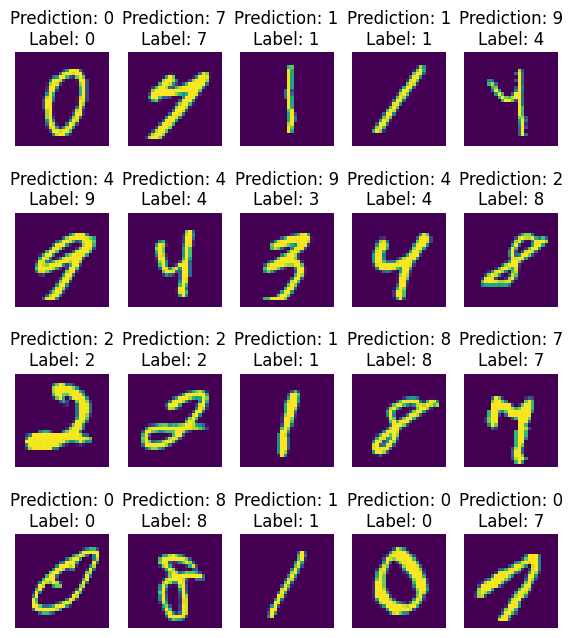

In [ ]:
# Evaluate the model on the plot_images
model.eval()

with torch.no_grad():
    plot_outputs = model(plot_images)
    plot_preds = torch.argmax(plot_outputs, dim=-1)

# Plot and show the labels
fig, axs = plt.subplots(4, 5, figsize=(7, 8))

for i, ax in enumerate(axs.flatten()):
    image = plot_images[i]
    label = plot_labels[i]
    pred = plot_preds[i]

    ax.imshow(image.squeeze(), cmap="viridis")
    ax.set_title(f"Prediction: {pred}\nLabel: {label}")
    ax.axis("off")
plt.show()

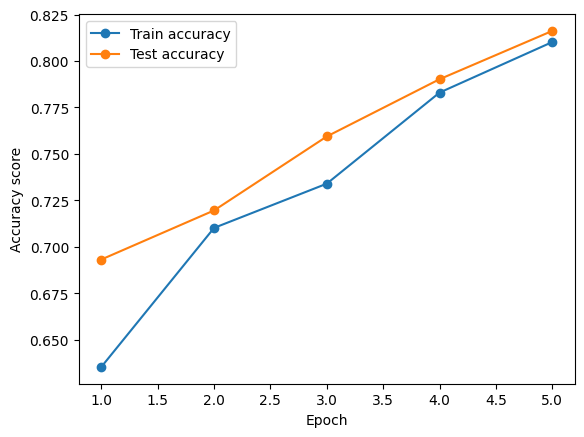

In [ ]:
# Plot training curves
xs = 1 + torch.arange(NUM_EPOCHS)
plt.plot(xs, train_metrics, "o-", label="Train accuracy")
plt.plot(xs, test_metrics, "o-", label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()